In [1]:
import pandas as pd

In [2]:
'''
MacOS专用字体设置
MacOS 系统中使用的中文字体路径
适用于MacOS15版本
可直接复制到代码中使用
'''
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置字体路径
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 加载字体
my_font = font_manager.FontProperties(fname=font_path)

# 设置为默认字体
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [3]:
df =pd.read_excel('员工离职预测模型.xlsx')

In [4]:
df.head()

,工资,满意度,考核得分,工程数量,月工时,工龄,离职
0,低,3.8,0.53,2,157,3,1
1,中,8.0,0.86,5,262,6,1
2,中,1.1,0.88,7,272,4,1
3,低,7.2,0.87,5,223,5,1
4,低,3.7,0.52,2,159,3,1


In [5]:
df.isnull().sum()

工资      0
满意度     0
考核得分    0
工程数量    0
月工时     0
工龄      0
离职      0
dtype: int64

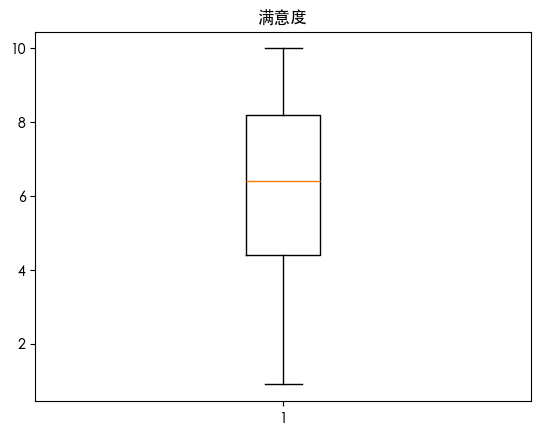

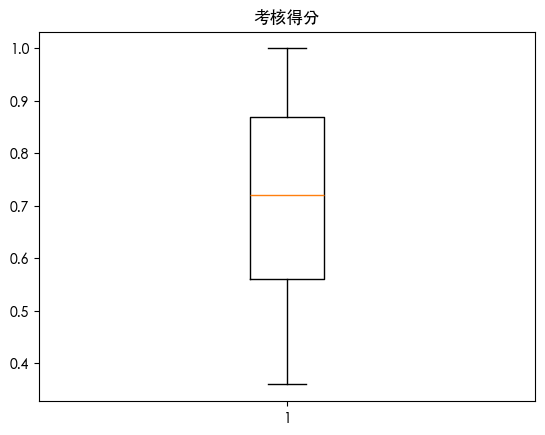

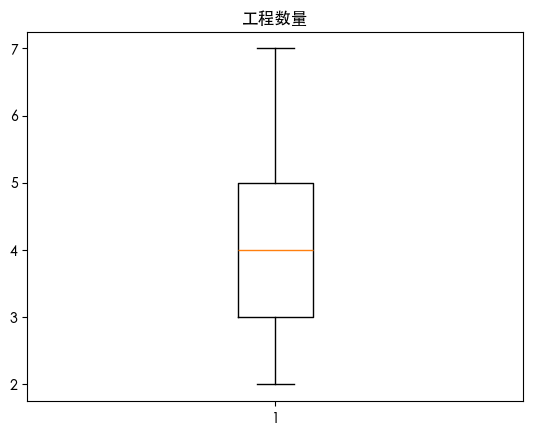

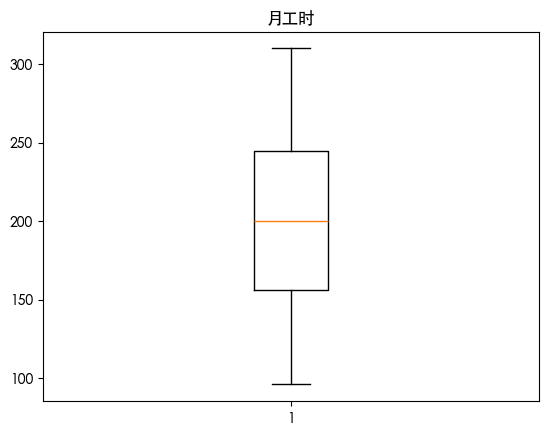

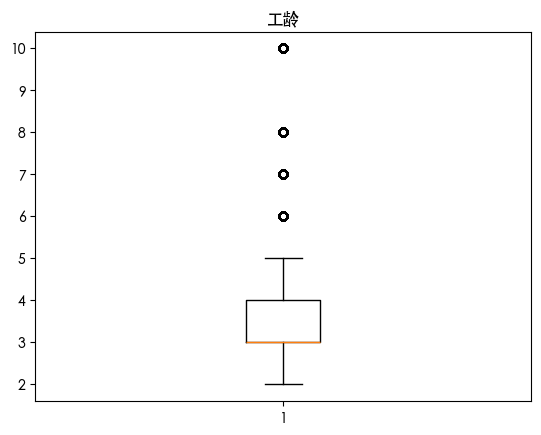

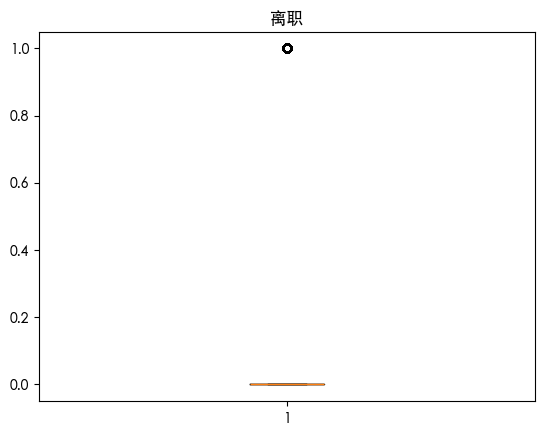

In [9]:
for col in df.select_dtypes(include=['number']).columns:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()


In [4]:
df['工资'] = df['工资'].map({'低': 0, '中': 1, '高': 2})

In [5]:
col = '工龄'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[f'{col}_is_outlier'] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['离职'])
y = df['离职']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 决策树

In [8]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2227   47]
 [  19  707]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2274
           1       0.94      0.97      0.96       726

    accuracy                           0.98      3000
   macro avg       0.96      0.98      0.97      3000
weighted avg       0.98      0.98      0.98      3000



In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [0.97625    0.97833333 0.96958333 0.97541667 0.98      ]
平均准确率：0.9759 (+/- 0.0071)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dtc = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,           # 使用所有 CPU 核心加速
    verbose=1            # 显示过程
)

grid_search.fit(X_train, y_train)

print("最佳参数：", grid_search.best_params_)
print("最佳交叉验证得分：%.4f" % grid_search.best_score_)

best_dtc = grid_search.best_estimator_
y_pred = best_dtc.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\n=== 测试集结果 ===")
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))
print("\n分类报告：")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
最佳参数： {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
最佳交叉验证得分：0.9564

=== 测试集结果 ===
混淆矩阵：
[[2236   38]
 [  21  705]]

分类报告：
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2274
           1       0.95      0.97      0.96       726

    accuracy                           0.98      3000
   macro avg       0.97      0.98      0.97      3000
weighted avg       0.98      0.98      0.98      3000



# 随机森林

In [22]:
from sklearn.ensemble import RandomForestClassifier

rm = RandomForestClassifier(random_state=42)
rm.fit(X_train, y_train)
y_pred = rm.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2268    6]
 [  20  706]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2274
           1       0.99      0.97      0.98       726

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [24]:
scores = cross_val_score(rm, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [0.99041667 0.99041667 0.98833333 0.99083333 0.99208333]
平均准确率：0.9904 (+/- 0.0024)


# GBDT

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

GBDT = GradientBoostingClassifier(random_state=42)
GBDT.fit(X_train, y_train)
y_pred = GBDT.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2249   25]
 [  53  673]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2274
           1       0.96      0.93      0.95       726

    accuracy                           0.97      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



In [26]:
scores = cross_val_score(GBDT, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [0.97333333 0.97625    0.97708333 0.97708333 0.97458333]
平均准确率：0.9757 (+/- 0.0030)


# 朴素贝叶斯

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
y_pred_proba = nb.predict_proba(X_test)[:, 1]  # 离职概率（正类概率）

print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_nb))
print("\n分类报告：")
print(classification_report(y_test, y_pred_nb))

print("\n前5个样本的离职概率：", y_pred_proba[:5])

混淆矩阵：
[[2071  203]
 [ 293  433]]

分类报告：
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2274
           1       0.68      0.60      0.64       726

    accuracy                           0.83      3000
   macro avg       0.78      0.75      0.76      3000
weighted avg       0.83      0.83      0.83      3000


前5个样本的离职概率： [0.0299359  0.07851404 0.00413399 0.63947954 0.12246857]


# LDA

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
y_pred_lda = LDA.predict(X_test)
y_pred_proba_lda = LDA.predict_proba(X_test)[:, 1]

print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_lda))
print("\n分类报告：")
print(classification_report(y_test, y_pred_lda))

混淆矩阵：
[[2096  178]
 [ 523  203]]

分类报告：
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      2274
           1       0.53      0.28      0.37       726

    accuracy                           0.77      3000
   macro avg       0.67      0.60      0.61      3000
weighted avg       0.74      0.77      0.74      3000



# XGBoost

In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_xgb))
print("\n分类报告：")
print(classification_report(y_test, y_pred_xgb))


混淆矩阵：
[[2260   14]
 [  29  697]]

分类报告：
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2274
           1       0.98      0.96      0.97       726

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

